# Test the AGDC2 API functions

* list cells
* list tiles
* get nbar/pqa tiles data.
* compute on the data
* pqa masks

In [2]:
!echo "PYTHONPATH: $PYTHONPATH || GDAL:  $GDAL_DATA"
!which python

import sys
paths=sys.path
#paths.append('/g/data1/u46/fxz547/Githubz/agdc-v2')
paths.insert(0,'/g/data1/u46/fxz547/Githubz/agdc-v2')  #prepend a path


PYTHONPATH:  || GDAL:  /g/data/u46/fxz547/anaconda2/share/gdal/
/g/data/u46/fxz547/anaconda2/bin/python


In [3]:
# do this again after insert python path below
import imp
imp.find_module('datacube/api')  # require python path below

(None, '/g/data1/u46/fxz547/Githubz/agdc-v2/datacube/api', ('', '', 5))

In [4]:
%matplotlib inline
from IPython.display import display
from collections import defaultdict

import xarray as xr
import xarray.ufuncs

from datacube.api import API
from datacube.index import index_connect
from datacube.config import LocalConfig
from datacube.api._conversion import to_datetime
from datacube.api import make_mask #, describe_flags

In [5]:
force_prod = True
if force_prod:
    prod_config = LocalConfig.find(['/g/data/v10/public/modules/agdc-py2-prod/1.0.2/datacube.conf'])
    prod_index = index_connect(prod_config, application_name='api-WOfS-dev')
    dc = API(prod_index)
else:
    dc = API(application_name='api-WOfS-dev')

In [6]:
qdict={"product":"nbar", "longitude": (100,160), "latitude":(0.0,-55), "time":('1900-01-01', '2016-03-20')}

print qdict

{'latitude': (0.0, -55), 'product': 'nbar', 'longitude': (100, 160), 'time': ('1900-01-01', '2016-03-20')}


In [7]:

# bonding AOI:
dc.list_cells(product='nbar', longitude=(149,150), latitude=(-40,-35.5), time=('2006-01-01', '2006-03-20'))

# all NBAR cells dc.list_cells(product='nbar')

#dc.list_cells(product='nbar', longitude=149, latitude=-35, time=('1990', '2015'))

[(14, -45),
 (14, -44),
 (14, -43),
 (15, -45),
 (15, -44),
 (15, -43),
 (15, -42),
 (15, -41),
 (15, -40),
 (16, -42),
 (16, -41),
 (16, -40)]

In [8]:
cells = dc.list_cells(**qdict)
print ("number of cells=",len(cells))
print (cells[:10])

('number of cells=', 1200)
[(-20, -33), (-20, -32), (-20, -31), (-20, -30), (-20, -29), (-20, -28), (-20, -27), (-20, -26), (-20, -25), (-20, -24)]


In [10]:
all_tiles= dc.list_tiles(cells,**qdict)

len(all_tiles)

208040

In [ ]:
tiles= dc.list_tiles

## Pick a cell, covers Lake George and north Canberra including Lake Burley Griffin.

In [11]:
cells = [(15, -40)]  #define it to focus on this cell covering Canberra
all_tiles = dc.list_tiles(cells )#, product='nbar')  #, platform='LANDSAT_5')
len(all_tiles)
#print nbar_tiles

659

In [12]:
pq_tiles = dc.list_tiles(cells, product='nbar', platform='LANDSAT_8')#, time=('2000', '2005'))
len(pq_tiles)

68

In [13]:
pq_tiles = dc.list_tiles(cells, product='nbar', platform='LANDSAT_7')#, time=('2000', '2005'))
len(pq_tiles)

64

In [14]:
nbar_tiles = dc.list_tiles(cells, product='nbar', platform='LANDSAT_8')


print (type(nbar_tiles), len(nbar_tiles))


pq_tiles = dc.list_tiles(cells, product='pqa', platform='LANDSAT_8') #, time=('2000', '2007'))
len(pq_tiles)
#print pq_tiles  # a huge list

(<type 'list'>, 68)


68

In [16]:
# 1 dem tile per cell
    
dem_tile =  dc.list_tiles(cells, product='DEM')  # a list with one element

In [22]:
print dem_tile[0]  # the first element of the list is a tuple
print len(dem_tile[0])

({'xy_index': (15, -40), 'storage_type': u'DEM', u'time': 951134040.0}, {'path': '/g/data/rs0/tiles/EPSG3577/SRTM_DEM/SRTM_DEM_15_-40_20000221115400000000.nc', 'description': u'DEM 25 metre, 100km tile', 'metadata': {u'platform': {u'code': u'SRTM'}, u'product_type': u'DEM', u'instrument': {u'name': u'SIR'}}})
2


In [21]:
for item in dem_tile[0]:
    print item

{'xy_index': (15, -40), 'storage_type': u'DEM', u'time': 951134040.0}
{'path': '/g/data/rs0/tiles/EPSG3577/SRTM_DEM/SRTM_DEM_15_-40_20000221115400000000.nc', 'description': u'DEM 25 metre, 100km tile', 'metadata': {u'platform': {u'code': u'SRTM'}, u'product_type': u'DEM', u'instrument': {u'name': u'SIR'}}}


In [26]:
# Now how to get the values of those attributes
# for this particular tile dem_tile[0] which is a tuple with 2 elements
my_tile=dem_tile[0]
cellindex=my_tile[0].get('xy_index')
epocsec=my_tile[0].get('time')

path2file=my_tile[1].get('path')

metadict=my_tile[1].get('metadata')

print (cellindex, epocsec, path2file, metadict)
    

((15, -40), 951134040.0, '/g/data/rs0/tiles/EPSG3577/SRTM_DEM/SRTM_DEM_15_-40_20000221115400000000.nc', {u'platform': {u'code': u'SRTM'}, u'product_type': u'DEM', u'instrument': {u'name': u'SIR'}})


## Group things together - under development

Our dictionary will be in the format:
```python
tile_store[cell][time][product]
```
It will contain the tile query and tile attributes.

### Format:
```python
tile_store = {
    cell: {
        timestamp: {
            product: (tile_query, tile_attrs)
        }
    }
}
```

### Example:

```python
tile_store = {
    (-15, -40): {
        datetime(2006, 7, 8, 1, 53, 0): {
            'nbar: (
                {
                    'storage_type': u'ls5_nbar_albers',
                    'time': 1138327352.6250501,
                    'xy_index': (-15, -40)
                },
                {
                    'description': u'Landsat 5 NBAR 25 metre, 100km tile (EPSG:3577)',
                    'metadata': {
                        u'instrument': {u'name': u'TM'},
                        'platform': {u'code': u'LANDSAT_5'},
                        'product_type': u'nbar'
                    },
                    'path': '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_-15_-40_2006.nc'
                })
        }
    }
}
```

In [53]:
def get_tile_store(cells, **kwargs): #product_code=None, satellite_code=None, date_interval=None):
    # eg, cells = [(15, -40)]  #cover Canberra
    #nbar_tiles = dc.list_tiles(cells, product='nbar', platform='LANDSAT_8') #,time=('2000', '2007'))
    #pq_tiles = dc.list_tiles(cells, product='pqa', platform='LANDSAT_8')   #, time=('2000', '2007'))


    tiles = dc.list_tiles(cells, **kwargs)#, platform=satellite_code)# time_issue, time=date_interval) 
    
    # tile_store = defaultdict(lambda: defaultdict(dict))  # a nested dictionary
    tile_store=[]
    
    for tile_query, tile_info in tiles:  # tiles is a list of tuple with 2 elements=(tile_query, tile_info)
        cell = tile_query['xy_index']
        time = tile_query['time']
        product = tile_info['metadata']['product_type']
        platform = tile_info['metadata']['platform']['code']
        path2file=tile_info.get('path')
        #debug print(time)
        key=(cell, time, platform)
        #tile_store.append( (cell, time, product, path2file) )
        tile_store.append( (cell, time, platform, product, tile_query,path2file) )
        
    return tile_store
####################################################################
    


In [56]:
qdict={"product":"DEM"}
#qdict={"product":"nbar"}
#qdict={"product":"pqa"}
tile_store=get_tile_store([(15, -40)], **qdict) 

print  len(tile_store)
for atile in tile_store[:5]:
    print  to_datetime(timestamp)
    print  atile

1
2006-02-10 23:40:44.372000+00:00
((15, -40), 951134040.0, u'SRTM', u'DEM', {'xy_index': (15, -40), 'storage_type': u'DEM', u'time': 951134040.0}, '/g/data/rs0/tiles/EPSG3577/SRTM_DEM/SRTM_DEM_15_-40_20000221115400000000.nc')


In [67]:
qdict={"product":"nbar"}
#qdict={"product":"pqa"}
nbar_tile_store=get_tile_store([(15, -40)], **qdict) 

print  len(nbar_tile_store)
for atile in nbar_tile_store[:5]:
    print  to_datetime(timestamp)
    print  atile

220
2006-02-10 23:40:44.372000+00:00
((15, -40), 1138232422.2250061, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138232422.2250061}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_2006.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1138232446.3400631, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138232446.3400631}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_2006.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1138837603.1170881, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138837603.1170881}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_2006.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1138837627.090081, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138837627.090081}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_

In [68]:
qdict={"product":"pqa"}
#qdict={"product":"pqa"}
pqa_tile_store=get_tile_store([(15, -40)], **qdict) 

print  len(pqa_tile_store)
for atile in pqa_tile_store[:5]:
    print  to_datetime(timestamp)
    print  atile

218
2006-02-10 23:40:44.372000+00:00
((15, -40), 1381621230.0038719, u'LANDSAT_7', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls7_pq_albers', u'time': 1381621230.0038719}, '/g/data/rs0/tiles/EPSG3577/LS7_ETM_PQ/15_-40/LS7_ETM_PQ_3577_15_-40_20131012234030003872.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1382226380.5723231, u'LANDSAT_7', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls7_pq_albers', u'time': 1382226380.5723231}, '/g/data/rs0/tiles/EPSG3577/LS7_ETM_PQ/15_-40/LS7_ETM_PQ_3577_15_-40_20131019234620572323.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1382226404.5278001, u'LANDSAT_7', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls7_pq_albers', u'time': 1382226404.5278001}, '/g/data/rs0/tiles/EPSG3577/LS7_ETM_PQ/15_-40/LS7_ETM_PQ_3577_15_-40_20131019234644527800.nc')
2006-02-10 23:40:44.372000+00:00
((15, -40), 1373326796.1645319, u'LANDSAT_7', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls7_pq_albers', u'time': 1373326796.1645319}, '/g/data/rs

In [69]:
nbarpqa= nbar_tile_store + pqa_tile_store
#sorted_nbarpqa= sorted(nbarpqa)
print len(nbarpqa)


438


In [ ]:
acquisition_id,satellite,start_datetime,end_datetime,end_datetime_year,end_datetime_month,x_index,y_index,xy,datasets
308465,LS7,2014-07-04 23:34:28,2014-07-04 23:34:52,2014,7,152,-31,"(152,-31)","{{ARG25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS7_ETM/152_-031/2014/LS7_ETM_NBAR_152_-031_2014-07-04T23-34-28.tif},{PQ25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS7_ETM/152_-031/2014/LS7_ETM_PQA_152_-031_2014-07-04T23-34-28.tif}}"
308491,LS8,2014-07-12 23:36:48,2014-07-12 23:37:12,2014,7,152,-31,"(152,-31)","{{ARG25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI_TIRS/152_-031/2014/LS8_OLI_TIRS_NBAR_152_-031_2014-07-12T23-36-48.tif},{PQ25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI_TIRS/152_-031/2014/LS8_OLI_TIRS_PQA_152_-031_2014-07-12T23-36-48.tif}}"
308511,LS8,2014-07-28 23:36:52,2014-07-28 23:37:16,2014,7,152,-31,"(152,-31)","{{ARG25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI_TIRS/152_-031/2014/LS8_OLI_TIRS_NBAR_152_-031_2014-07-28T23-36-52.tif},{PQ25,/g/data/rs0/tiles/EPSG4326_1deg_0.00025pixel/LS8_OLI_TIRS/152_-031/2014/LS8_OLI_TIRS_PQA_152_-031_2014-07-28T23-36-52.tif}}"


In [78]:

nbarpqa.sort()

for i in range(0, len(nbarpqa),2):
    print i
    if nbarpqa[i][1] == nbarpqa[i+1][1]:
        print nbarpqa[i]
        print nbarpqa[i+1]
    else:
        print ("Warning: missing tiles")
    

0
((15, -40), 1138232422.2250061, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138232422.2250061}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_2006.nc')
((15, -40), 1138232422.2250061, u'LANDSAT_5', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls5_pq_albers', u'time': 1138232422.2250061}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_PQ/15_-40/LS5_TM_PQ_3577_15_-40_20060125234022225006.nc')
2
((15, -40), 1138232446.3400631, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storage_type': u'ls5_nbar_albers', u'time': 1138232446.3400631}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_NBAR/LS5_TM_NBAR_3577_15_-40_2006.nc')
((15, -40), 1138232446.3400631, u'LANDSAT_5', u'pqa', {'xy_index': (15, -40), 'storage_type': u'ls5_pq_albers', u'time': 1138232446.3400631}, '/g/data/rs0/tiles/EPSG3577/LS5_TM_PQ/15_-40/LS5_TM_PQ_3577_15_-40_20060125234046340063.nc')
4
((15, -40), 1138837603.1170881, u'LANDSAT_5', u'nbar', {'xy_index': (15, -40), 'storag

# Retrieve the imagery tiles data via API

* are stored as netcdf (bands-slices)
* nbar
* pqa
* DEM
* pixel classification (water)


In [9]:
# focus a specific cell pair nbar and pqa tiles according time. then get the xarray data for processing
cell=(15, -40); stack = tile_store[cell]

for time in sorted(stack)[:2] :
    tileset = stack[time]
    
    if 'nbar' in tileset and 'pqa' in tileset:
        print ("This cell has both nbar and pq data at time %s"% str(time))
    else:
        print "not a good time-sliced tile - we have missing data!"
        
    nbar_tile_query, nbar_tile_info = tileset['nbar']
    # This will get replaced by the semantic layer
    platform = nbar_tile_info['metadata']['platform']['code']
    if platform in ('LANDSAT_5', 'LANDSAT_7'):
        variables = ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_7']
    elif platform in ('LANDSAT_8'):
        variables = ['band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7']
        
    # get the nbar data as xarray.core.dataarray.DataArray
    #nbar_tile = dc.get_data_array_by_cell(variables=variables, set_nan=True, **nbar_tile_query)
    nbar_tile = dc.get_data_array_by_cell(variables=variables, set_nan=False, **nbar_tile_query)
    
    
    pq_tile_query, pq_tile_info = tileset['pqa']
    pq_tile_ds =  dc.get_dataset_by_cell(**pq_tile_query)
    pq_tile = pq_tile_ds['pixelquality']
    print "{:%c}\tnbar shape: {}\tpq shape: {}".format(to_datetime(time), nbar_tile.shape, pq_tile.shape)
    
    #print pq_tile.shape
    break # Just do the first one as a test...

This cell has both nbar and pq data at time 1365723995.39
Thu Apr 11 23:46:35 2013	nbar shape: (6, 4000, 4000)	pq shape: (4000, 4000)


In [12]:
print type(nbar_tile)
print nbar_tile.attrs["_FillValue"]
print nbar_tile.indexes
print nbar_tile.dims
print nbar_tile.coords

<class 'xarray.core.dataarray.DataArray'>
-999
variable: Index([u'band_2', u'band_3', u'band_4', u'band_5', u'band_6', u'band_7'], dtype='object', name=u'variable')
y: Float64Index([-3900012.5, -3900037.5, -3900062.5, -3900087.5, -3900112.5,
                 -3900137.5, -3900162.5, -3900187.5, -3900212.5, -3900237.5,
                 ...
                 -3999762.5, -3999787.5, -3999812.5, -3999837.5, -3999862.5,
                 -3999887.5, -3999912.5, -3999937.5, -3999962.5, -3999987.5],
                dtype='float64', name=u'y', length=4000)
x: Float64Index([1500012.5, 1500037.5, 1500062.5, 1500087.5, 1500112.5, 1500137.5,
                 1500162.5, 1500187.5, 1500212.5, 1500237.5,
                 ...
                 1599762.5, 1599787.5, 1599812.5, 1599837.5, 1599862.5, 1599887.5,
                 1599912.5, 1599937.5, 1599962.5, 1599987.5],
                dtype='float64', name=u'x', length=4000)
(u'variable', u'y', u'x')
Coordinates:
    time      datetime64[ns] 2013-04-11T23

In [17]:
import numpy 
nar=nbar_tile.values  #memory-out-of-limit on Raijin, takes some time to load into mem

print type(nar), nar.shape

print numpy.sum(nar != -999)

<type 'numpy.ndarray'> (6, 4000, 4000)
0


In [18]:
print pq_tile

<xarray.DataArray 'pixelquality' (y: 4000, x: 4000)>
dask.array<getitem..., shape=(4000, 4000), dtype=int16, chunksize=(4000, 4000)>
Coordinates:
    time     datetime64[ns] 2013-04-11T23:46:35.385577
  * y        (y) float64 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 -3.9e+06 ...
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
Attributes:
    units: 1
    long_name: Quality Control
    flags_definition: {u'cloud_shadow_acca': {u'bit_index': 12, u'description': u'Cloud Shadow (ACCA)', u'value': 0}, u'cloud_acca': {u'bit_index': 10, u'description': u'Cloud (ACCA)', u'value': 0}, u'land_obs': {u'bit_index': 9, u'description': u'Land observation', u'value': 1}, u'band_1_saturated': {u'bit_index': 0, u'description': u'Band 1 is saturated', u'value': 0}, u'contiguity': {u'bit_index': 8, u'description': u'All bands for this pixel contain non-null values', u'value': 1}, u'band_2_saturated': {u'bit_i...


In [13]:
ar = nbar_tile.load()

In [54]:
#Ga pond (latcoord, loncoord) from the top left corner 
#149.16032 -35.34236 ==>Transformed to ==> 1552370.25991 -3964606.702
ga_xlon= (1552370.25991-1500000)/25
ga_ylat= (3964606.702 -3900000.)/25
print ga_ylat, ga_xlon

2584.26808 2094.8103964


In [14]:
print ar[:,2584,2095]
print ar[:,39,39]
print ar[:,3999,3900]
print ar[:,39,3900]
print ar[:,3999,39]

<xarray.DataArray u'ls8_nbar_albers' (variable: 6)>
array([-999, -999, -999, -999, -999, -999], dtype=int16)
Coordinates:
    time      datetime64[ns] 2013-04-11T23:46:35.385577
    y         float64 -3.965e+06
    x         float64 1.552e+06
  * variable  (variable) <U6 u'band_2' u'band_3' u'band_4' u'band_5' ...
Attributes:
    _FillValue: -999
<xarray.DataArray u'ls8_nbar_albers' (variable: 6)>
array([-999, -999, -999, -999, -999, -999], dtype=int16)
Coordinates:
    time      datetime64[ns] 2013-04-11T23:46:35.385577
    y         float64 -3.901e+06
    x         float64 1.501e+06
  * variable  (variable) <U6 u'band_2' u'band_3' u'band_4' u'band_5' ...
Attributes:
    _FillValue: -999
<xarray.DataArray u'ls8_nbar_albers' (variable: 6)>
array([-999, -999, -999, -999, -999, -999], dtype=int16)
Coordinates:
    time      datetime64[ns] 2013-04-11T23:46:35.385577
    y         float64 -4e+06
    x         float64 1.598e+06
  * variable  (variable) <U6 u'band_2' u'band_3' u'band_4' u'ba

In [48]:
#"Lake Berly-Griffin At long: 149.13356, lat: -35.29351 WOfS 99.5%"
#transformed to (1550690.105 -3958900.24898)
y=(3900000 -3958900.24898)/25  #lat
x= (1550690.105-1500000.)/25   #lon
print y, x

-2356.0099592 2027.6042


In [15]:
print ar[:,2356,2028]  #lake berleyGriffin in cell 15_-40

<xarray.DataArray u'ls8_nbar_albers' (variable: 6)>
array([-999, -999, -999, -999, -999, -999], dtype=int16)
Coordinates:
    time      datetime64[ns] 2013-04-11T23:46:35.385577
    y         float64 -3.959e+06
    x         float64 1.551e+06
  * variable  (variable) <U6 u'band_2' u'band_3' u'band_4' u'band_5' ...
Attributes:
    _FillValue: -999


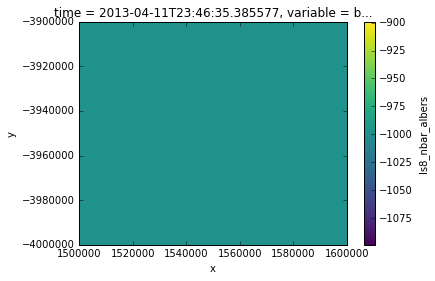

In [10]:
#nbar_tile[0].plot()
nbar_tile[0].plot()

Plot a low-res copy of no-data

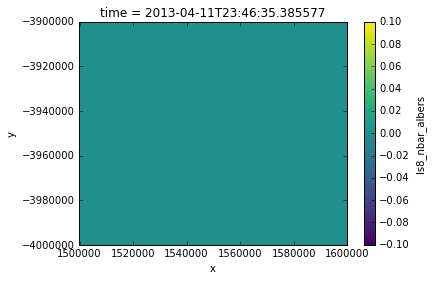

In [11]:
no_data_tile = (~xr.ufuncs.isfinite(nbar_tile)).any(dim='variable')
no_data_tile[::10, ::10].plot.imshow()

## Pixel Masking

In [19]:
nump= pq_tile.load()
print type(nump)

<class 'xarray.core.dataarray.DataArray'>


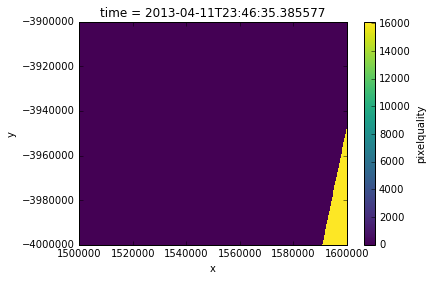

In [20]:
nump.plot()

In [21]:
print describe_flags(pq_tile)

Bits are listed from the MSB (bit 13) to the LSB (bit 0)
Bit     Value   Flag Name            Description
13      0       cloud_shadow_fmask   Cloud Shadow (Fmask)
12      0       cloud_shadow_acca    Cloud Shadow (ACCA)
11      0       cloud_fmask          Cloud (Fmask)
10      0       cloud_acca           Cloud (ACCA)
9       1       land_obs             Land observation
9       0       sea_obs              Sea observation
8       1       contiguity           All bands for this pixel contain non-null values
7       0       band_7_saturated     Band 7 is saturated
6       0       band_6_2_saturated   Band 6-2 is saturated
5       0       band_6_1_saturated   Band 6-1 is saturated
4       0       band_5_saturated     Band 5 is saturated
3       0       band_4_saturated     Band 4 is saturated
2       0       band_3_saturated     Band 3 is saturated
1       0       band_2_saturated     Band 2 is saturated
0       0       band_1_saturated     Band 1 is saturated


<class 'xarray.core.dataarray.DataArray'>


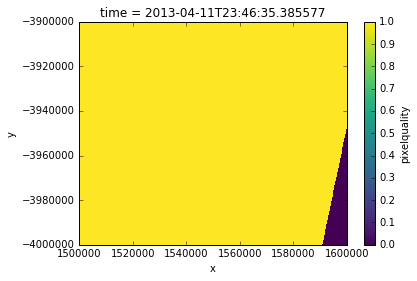

In [22]:
print type(pq_tile)
clouds_tile = ~make_mask(pq_tile, cloud_fmask=False, cloud_acca=False)
clouds_tile.plot()

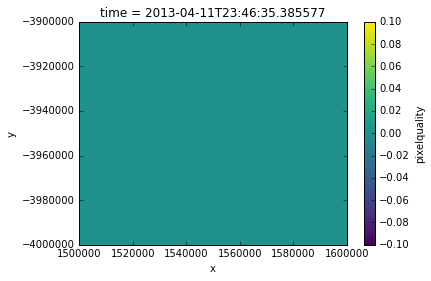

In [23]:
masked_tile = make_mask(pq_tile, cloud_fmask=True, contiguity=True)
masked_tile.plot()

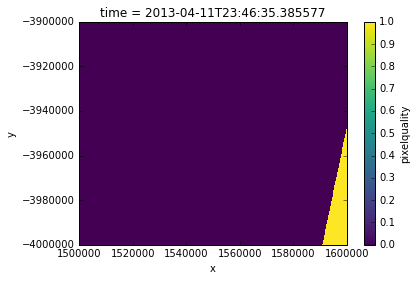

In [24]:
masked_tile = make_mask(pq_tile, land_obs=True)
masked_tile.plot()

In [24]:
#pq_tile.pixelquality[3900, 10].load()

pq_tile[3900, 10].load()

<xarray.DataArray 'pixelquality' ()>
array(13311, dtype=int16)
Coordinates:
    time     datetime64[ns] 2006-01-25T23:40:46.340063
    y        float64 -3.998e+06
    x        float64 1.5e+06
Attributes:
    units: 1
    long_name: Quality Control
    flags_definition: {u'cloud_shadow_acca': {u'bit_index': 12, u'description': u'Cloud Shadow (ACCA)', u'value': 0}, u'cloud_acca': {u'bit_index': 10, u'description': u'Cloud (ACCA)', u'value': 0}, u'land_obs': {u'bit_index': 9, u'description': u'Land observation', u'value': 1}, u'band_1_saturated': {u'bit_index': 0, u'description': u'Band 1 is saturated', u'value': 0}, u'contiguity': {u'bit_index': 8, u'description': u'All bands for this pixel contain non-null values', u'value': 1}, u'band_2_saturated': {u'bit_i...

In [26]:
pq_tile[3900, 10].values

array(13311, dtype=int16)

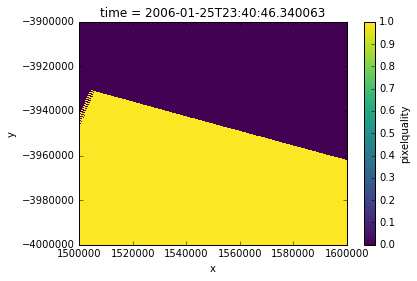

In [27]:
masked_tile = make_mask(pq_tile, contiguity=True)  # no data?
masked_tile.plot()

### Chunking
Sometimes the underlying data has different chunk sizes, and must be re-aligned to make use of dask functions.

We may have to align the datasets to perform operations such as `bitwise_and` (i.e. `&`).

In [ ]:
print "Clouds chunks: ", clouds_tile.chunks
print "No Data chunks: ", no_data_tile.chunks

if clouds_tile.chunks != no_data_tile.chunks:
    print "Re-chunking clouds!"
    clouds_tile = clouds_tile.chunk(no_data_tile.chunks)
else:
    print "Chunk alignment is OK!"

In [ ]:
clouds_with_data = (clouds_tile & ~no_data_tile)
clouds_with_data.plot()

In [ ]:
#How to run a program: %run testagdcv2_env.py